In [1]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

In [2]:
import pyref as rf
from pypxr.structure import PXR_SLD, PXR_MaterialSLD, PXR_Slab, PXR_Structure
from pypxr.reflectivity import PXR_ReflectModel
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import DEMove

# Experimental Configuration

In this notebook, we play arround with the idea that that the experiment could change in configuration between collecting s and p polarizaed data. Thus we will fit seperately s and p pol data and compare the results. 

C:\Users\hduva\AppData\Local\Temp\ipykernel_14424\506948675.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s_pol = _s_pol[(_s_pol["Q"] != .0757)][_s_pol["Q"] != 0.0740]
C:\Users\hduva\AppData\Local\Temp\ipykernel_14424\506948675.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_pol = _p_pol[(_p_pol["Q"] != .0757)][_p_pol["Q"] != 0.0740]


<Axes: xlabel='Q'>

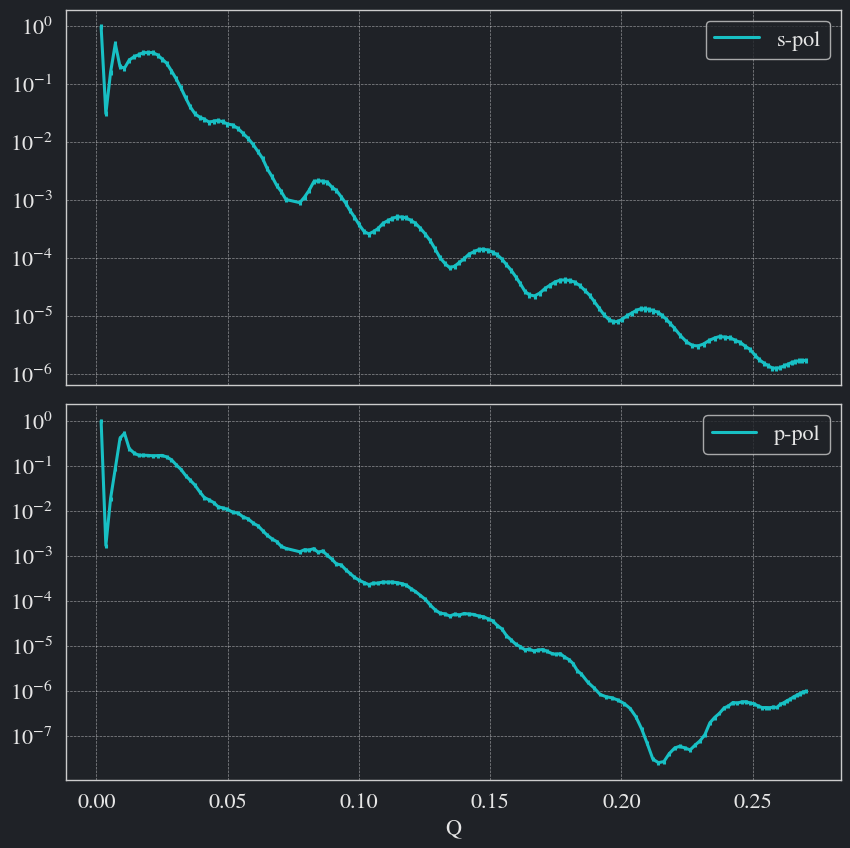

In [3]:
import matplotlib.pyplot as plt
db = rf.db()

#------------------------------------------------
# Load data
# Data loading is focused on the 283.7 ev data set
#------------------------------------------------

_s_pol = db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc")
_p_pol = db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc")

s_pol = _s_pol[(_s_pol["Q"] != .0757)][_s_pol["Q"] != 0.0740]
p_pol = _p_pol[(_p_pol["Q"] != .0757)][_p_pol["Q"] != 0.0740]

#------------------------------------------------
# Plot data
#------------------------------------------------

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={"hspace": 0.05})
s_pol.plot(ax=ax[0], label="s-pol", x = "Q", y = "Refl", yerr = "Err", logy=True)
p_pol.plot(ax=ax[1], label="p-pol", x = "Q", y = "Refl", yerr = "Err", logy=True)

In [4]:
# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

si_thick = znpc_mono_struct_file["Si"]["thickness"]
si_rough = znpc_mono_struct_file["Si"]["roughness"]
si_density = znpc_mono_struct_file["Si"]["density"]

sio2_thick = znpc_mono_struct_file["SiO2"]["thickness"]
sio2_rough = znpc_mono_struct_file["SiO2"]["roughness"]
sio2_density = znpc_mono_struct_file["SiO2"]["density"]

c_amor_thick = znpc_mono_struct_file["C"]["thickness"]
c_amor_rough = znpc_mono_struct_file["C"]["roughness"]
c_amor_density = znpc_mono_struct_file["C"]["density"]

znpc_thick = znpc_mono_struct_file["C32H16N8Zn"]["thickness"]
znpc_rough = znpc_mono_struct_file["C32H16N8Zn"]["roughness"]
znpc_density = znpc_mono_struct_file["C32H16N8Zn"]["density"]

[ 0.00049552+0.j -0.00448779+0.j]


(Parameter(value=-0.004487785909452915, name='ZnPc_zz', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None),
 Parameter(value=-0.004487785909452915, name='ZnPc_zz', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None),
 array([ 0.00049552+0.j, -0.00448779+0.j]))

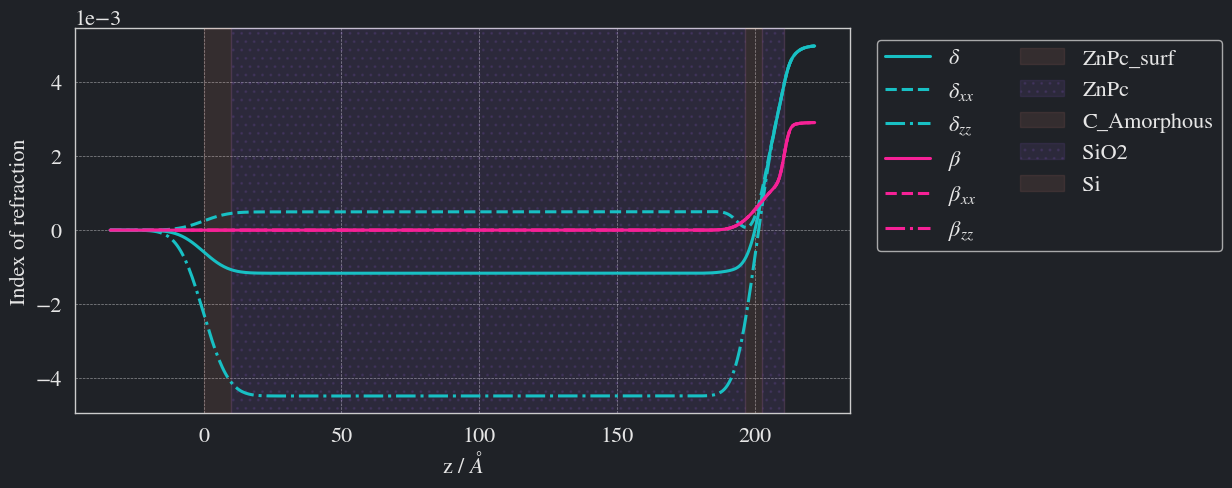

In [5]:
en = 283.7

n = znpc_oc(en, density = znpc_density)
print(n)

vac = PXR_MaterialSLD("", 0, en)(0, 0)
si = PXR_MaterialSLD("Si", 2.33, en, name="Si")(si_thick,si_rough)
sio2 = PXR_MaterialSLD("SiO2", sio2_density, en, name="SiO2")(sio2_thick,sio2_rough)
c_amor = PXR_MaterialSLD("C", c_amor_density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough)

znpc_surf_thick = 10

znpc = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick-znpc_surf_thick, znpc_rough)

znpc_surf = PXR_SLD(n, symmetry="uni", name = "ZnPc_surf")(znpc_surf_thick, znpc_rough)

# znpc_sub_surf = [PXR_SLD(ns[i], symmetry="uni", name = "ZnPc_sib_surf")(znpc_surf_thick, znpc_rough) for i, _ in enumerate(ens)]

# znpc_sub = [PXR_SLD(ns[i], symmetry="uni", name = "ZnPc_sub")(znpc_surf_thick, znpc_rough) for i, _ in enumerate(ens)]

struc: PXR_Structure = vac | znpc_surf | znpc | c_amor | sio2 | si

struc.plot()

znpc.sld.zz, znpc.sld.zz, n

In [6]:
#------------------------------------------------
# Constrain Model
#------------------------------------------------

# Independent of polarization

si.thick.setp(vary = False)
si.rough.setp(vary = False)

sio2.thick.setp(vary = None, constraint = sio2_thick)
sio2.rough.setp(vary = None, constraint = sio2_rough)
sio2.sld.density.setp(vary = True, bounds = (0,3))

c_amor.thick.setp(vary = None, constraint = c_amor_thick)
c_amor.rough.setp(vary = None, constraint = c_amor_rough)
c_amor.sld.density.setp(vary = True, bounds = (0,3))


def sld_constraint(slab: PXR_Slab, xx_bounds:tuple, zz_bounds: tuple):
    from numpy import array

    # Thick-Rough constraints
    slab.thick.setp(vary = True, bounds = slab.thick.value*array([.8, 1.2]))
    slab.rough.setp(vary = True, bounds = slab.rough.value*array([.8, 1.2]))

    slab.sld.xx.setp(vary = True, bounds = xx_bounds)
    slab.sld.ixx.setp(vary = True, bounds = xx_bounds)

    slab.sld.zz.setp(vary = True, bounds = zz_bounds)
    slab.sld.izz.setp(vary = True, bounds = zz_bounds)

sld_constraint(znpc_surf, xx_bounds = (-.003, .003), zz_bounds = (-.003, .003))
sld_constraint(znpc, xx_bounds = (0, .003), zz_bounds = (-.003, 0))

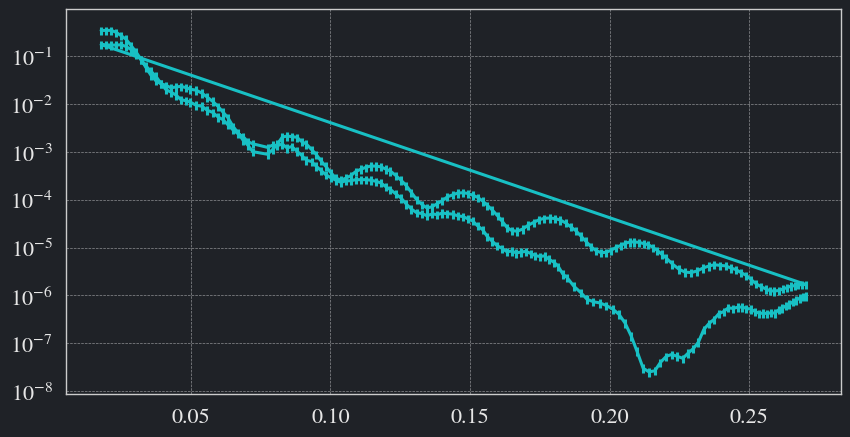

In [8]:
#------------------------------------------------
# Load Data
#------------------------------------------------

s_pol_ = s_pol.iloc[9:]
p_pol_ = p_pol.iloc[9:]

data = rf.to_refnx_dataset(s_pol_, pol = "sp", second_pol=p_pol_, error=.2)

data.plot()
plt.yscale("log")

In [9]:
import numpy as np

def sort_pars(pars, str_check, vary=None, not_check = " "):
    temp = []
    num = len(pars)
    for i in range(num):
        if str_check in pars[i].name and not_check not in pars[i].name:
            if vary == True:
                if pars[i].vary == True:
                    temp.append(pars[i])
            elif vary == False:
                if pars[i].vary == False:
                    temp.append(pars[i])
            else:
                temp.append(pars[i])
    return temp

0
No polarizations were chosen for model


c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\refnx\util\ErrorProp.py:87: RuntimeWarning: divide by zero encountered in log10
  return n * np.log10(k * a), np.absolute(n * da / (a * np.log(10)))
c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\refnx\util\ErrorProp.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  return n * np.log10(k * a), np.absolute(n * da / (a * np.log(10)))
c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\refnx\analysis\objective.py:1440: RuntimeWarning: Some of the transformed data was non-finite. Please check your datasets for points with zero or negative values.
  warnings.warn(
c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\refnx\analysis\objective.py:980: SyntaxWarning: invalid escape sequence '\A'
  ax2.set_xlabel("Q / $\AA^{-1}$")


ValueError: x and y must have same first dimension, but have shapes (281,) and (1,)

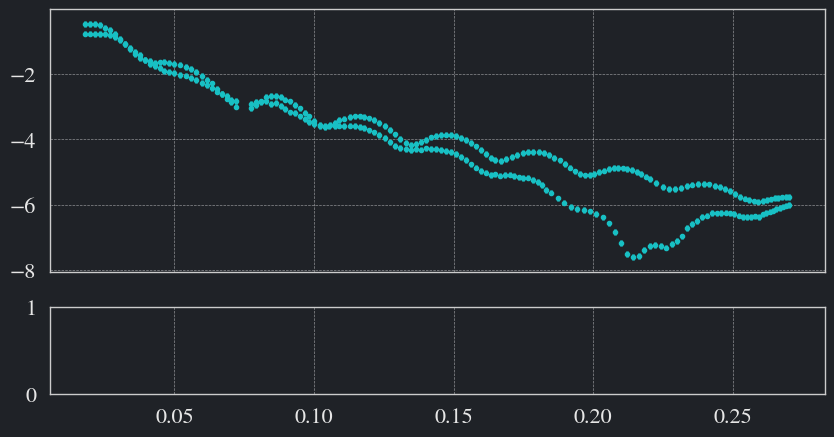

In [10]:
from pyref.fitting.logp import LogpExtra_rough as LogpExtra

#------------------------------------------------
# p - polarized data
#------------------------------------------------

model = PXR_ReflectModel(struc, pol = "spp", energy = en, name = "ZnPc Mono Layer", theta_offset=-.6, scale=.7)
model.scale.setp(vary = True, bounds = (0.6, 1.2))
model.bkg.setp(vary = True, bounds = (1e-12, p_pol["Refl"].min()))
model.theta_offset.setp(vary = True, bounds = (-2, 2))
model.en_offset.setp(vary = True, bounds = (-0.5, 0.5))

obj = Objective(model, data, transform=Transform("logY"))
lpe = LogpExtra(obj)
print(lpe(model, data))
obj.logp_extra = lpe

obj.plot(resid=True)

In [48]:
def fitter_func(obj: Objective, walkers_per_param = 10, steps_per_walker = 2, thin = 2, seed = 1):
    n_walkers = int(walkers_per_param*len(obj_p.varying_parameters()))
    steps = steps_per_walker*n_walkers

    move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7, gamma0=1), 0.05)]
    random_state = seed

    fitter = CurveFitter(obj, nwalkers=n_walkers, moves = move)
    fitter.initialise("prior")
    chain = fitter.sample(steps, random_state=random_state, nthin=thin)

    print(obj.varying_parameters())
    print(obj.chisqr() / (len(p_data.data[0]) - len(obj.varying_parameters())))
    obj.plot(resid = True)

    fig, ax = plt.subplots()
    lp = fitter.logpost
    ax.plot(-lp)

  0%|          | 0/680 [00:00<?, ?it/s]c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\refnx\_lib\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 680/680 [02:26<00:00,  4.65it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.893348 +/- 0.174, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.20776e-07 +/- 3.87e-07, bounds=[1e-12, 1.239001280359764e-06]>
<Parameter:  'en_offset'  , value=0.0631407 +/- 0.324, bounds=[-0.5, 0.5]>
<Parameter:'ZnPc_surf_thick', value=14.3131 +/- 4.58 , bounds=[5.0, 20.0]>
<Parameter:'ZnPc_surf_xx' , value=0.000141579 +/- 0.00162, bounds=[-0.003, 0.003]>
<Parameter:'ZnPc_surf_ixx', value=-6.66789e-05 +/- 0.00175, bounds=[-0.003, 0.003]>
<Parameter:'ZnPc_surf_zz' , value=-0.000150804 +/- 0.00199, bounds=[-0.003, 0.003]>
<Parameter:'ZnPc_surf_izz', value=8.55385e-05 +/- 0.00197, bounds=[-0.003, 0.003]>
<Parameter:'ZnPc_surf_rough', value=8.41989 +/- 3.29 , bounds=[3.60814, 14.43256]>
<Parameter: 'ZnPc_thick'  , value=199.812 +/- 98.8 , bounds=[93.2205, 372.882]>
<Parameter:   'ZnPc_xx'   , value=0.000858822 +/- 0.00106, bounds=[0.0, 

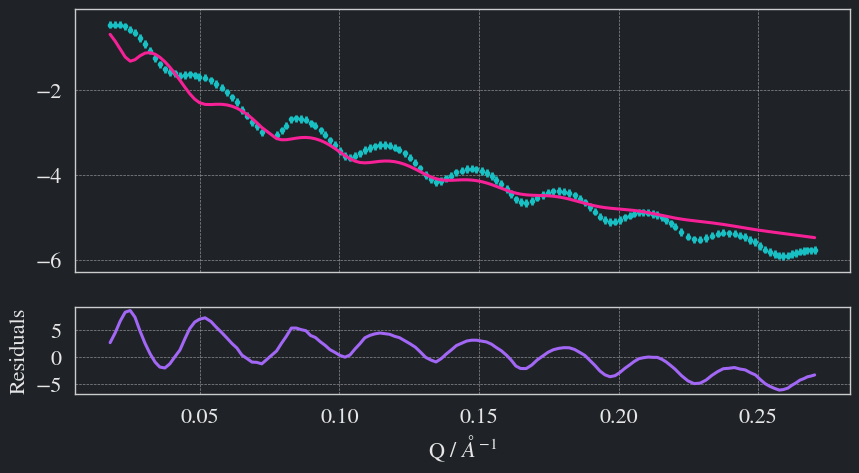

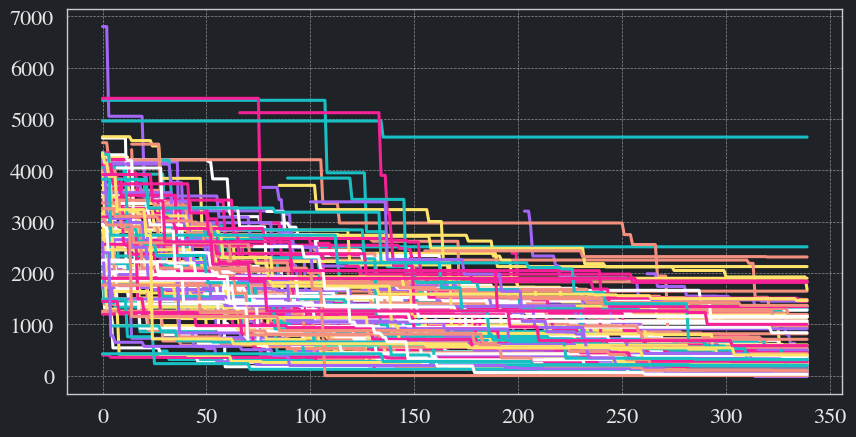

In [49]:
fitter_func(obj_s)

100%|██████████| 945/945 [01:21<00:00, 11.55it/s]


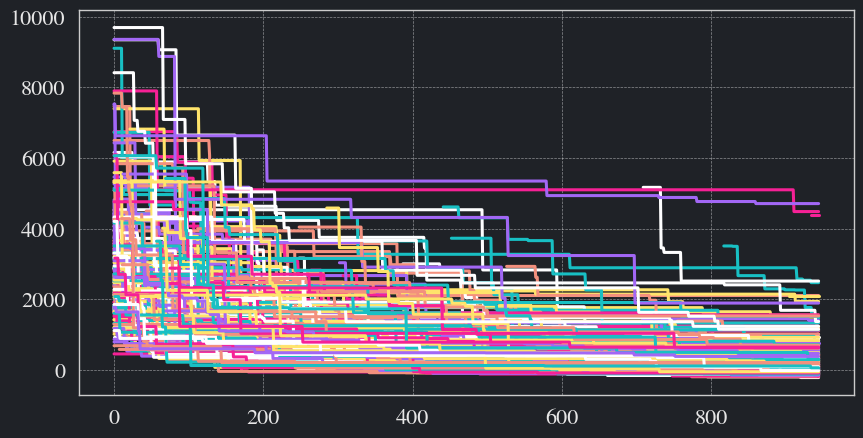

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.574521 +/- 0.315, bounds=[0.2, 1.2]>
<Parameter:     'bkg'     , value=5.04696e-10 +/- 3.42e-10, bounds=[1e-12, 1e-09]>
<Parameter:'dq - resolution', value=0.246066 +/- 0.162, bounds=[0.0, 0.5]>
<Parameter:  'q_offset'   , value=-0.0102129 +/- 0.0103, bounds=[-0.02, 0.01]>
<Parameter:'ZnPc_surf_thick', value=11.3214 +/- 6.21 , bounds=[0.0, 20.0]>
<Parameter:'ZnPc_surf_xx' , value=-0.000680115 +/- 0.00184, bounds=[-0.005, 0.002]>
<Parameter:'ZnPc_surf_ixx', value=0.000955076 +/- 0.00063, bounds=[0.0, 0.002]>
<Parameter:'ZnPc_surf_zz' , value=-0.00168159 +/- 0.00239, bounds=[-0.005, 0.002]>
<Parameter:'ZnPc_surf_izz', value=0.000939384 +/- 0.000685, bounds=[0.0, 0.002]>
<Parameter:'ZnPc_surf_rough', value=5.02732 +/- 3.32 , bounds=[0.0, 10.0]>
<Parameter:   'ZnPc_xx'   , value=0.000843189 +/- 0.000666, bounds=[0.0, 0.002]>
<Parameter:  'ZnPc_ixx

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

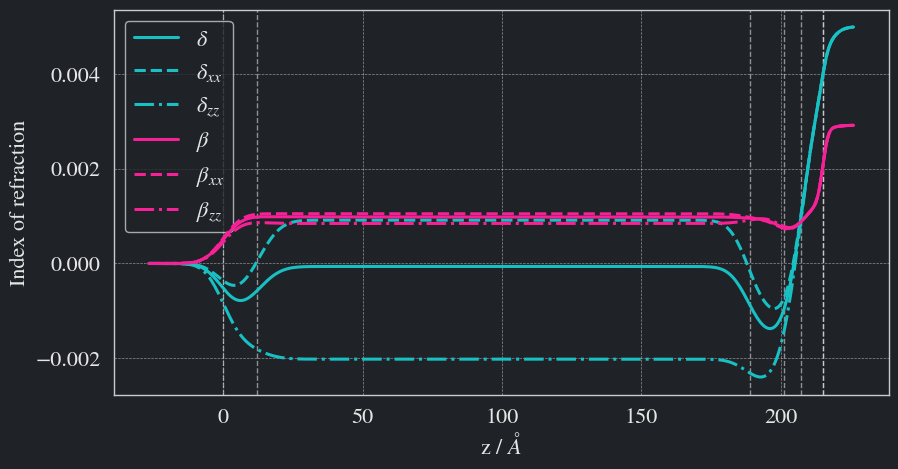

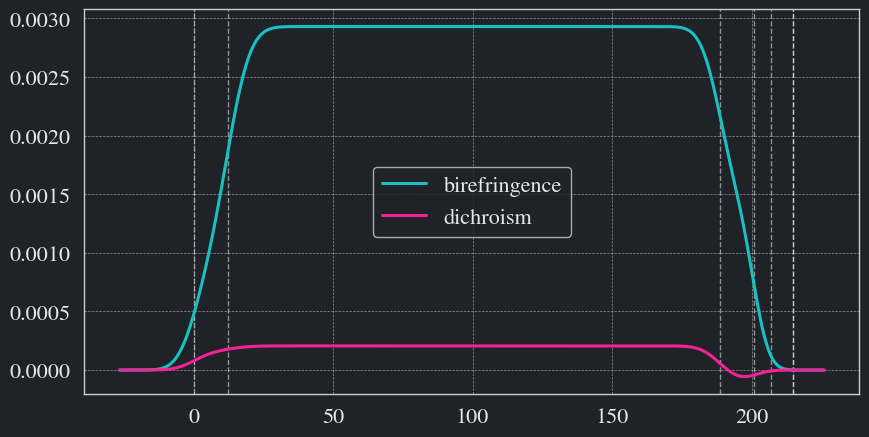

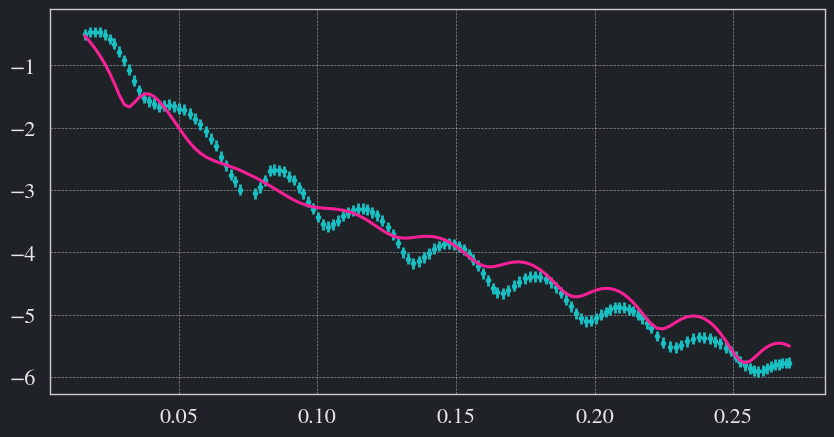

In [16]:
fitter = CurveFitter(obj_s, nwalkers=n_walkers, moves = move)
fitter.initialise("prior")
chain = fitter.sample(steps, random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)
plt.show()
structs[0].plot(difference=True)

print(obj_s.varying_parameters())
print(obj_s.chisqr())
obj_s.plot()

100%|██████████| 550/550 [02:00<00:00,  4.55it/s]


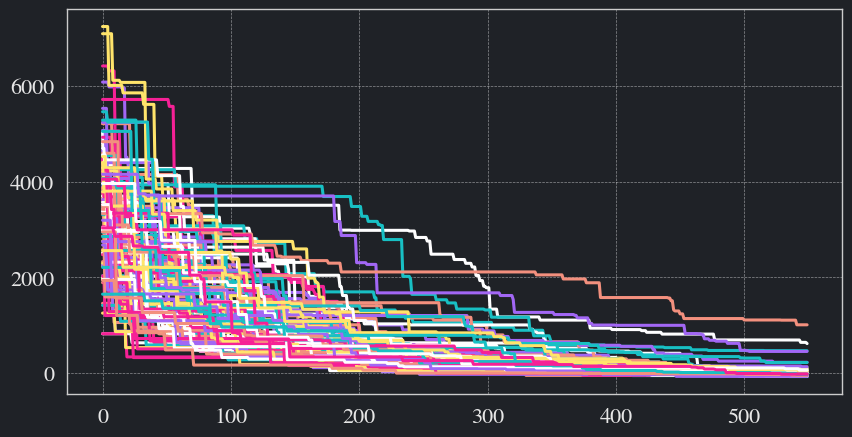

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.791898 +/- 0.154, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=9.17049e-09 +/- 8.43e-09, bounds=[1e-12, 2.5316362333630955e-08]>
<Parameter:  'en_offset'  , value=0.0349256 +/- 0.334, bounds=[-0.5, 0.5]>
<Parameter:'theta_offset_p', value=-0.911048 +/- 0.473, bounds=[-2.0, 1.0]>
<Parameter:'ZnPc_surf_xx' , value=0.000188116 +/- 0.000354, bounds=[0.0, 0.003]>
<Parameter:'ZnPc_surf_ixx', value=0.000247067 +/- 0.000559, bounds=[0.0, 0.003]>
<Parameter:'ZnPc_surf_zz' , value=-0.000853831 +/- 0.000402, bounds=[-0.003, 0.0]>
<Parameter:'ZnPc_surf_izz', value=0.000842465 +/- 0.000487, bounds=[0.0, 0.003]>
<Parameter: 'ZnPc_rough'  , value=5.17004 +/- 3.09 , bounds=[0.0, 10.0]>
<Parameter:     'rho'     , value=0.308915 +/- 0.534, bounds=[0.0, 3.0]>
<Parameter:     'rho'     , value=2.48753 +/- 0.427, bounds=[0.0, 3.0]>
4.511893979208858


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

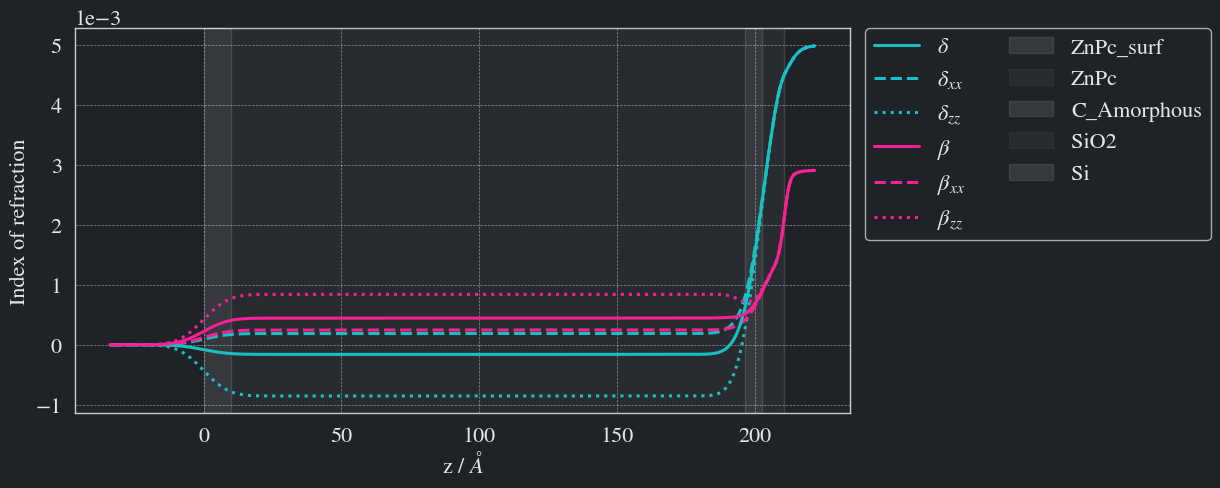

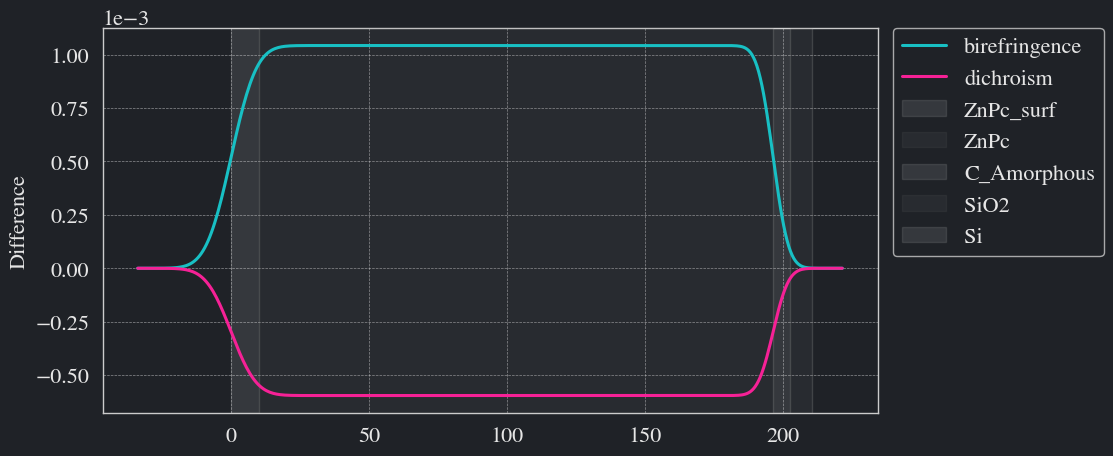

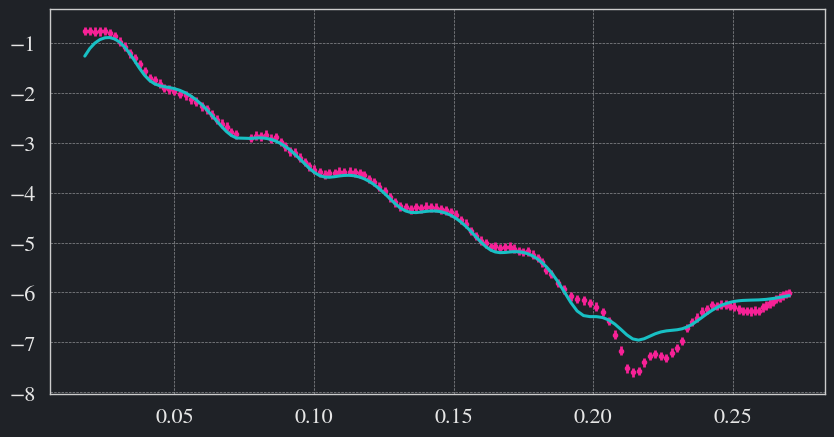

In [ ]:
n_walkers = int(10*len(obj_p.varying_parameters()))
steps = 5*n_walkers

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7, gamma0=1), 0.05)]
random_state = 120

fitter = CurveFitter(obj_p, nwalkers=n_walkers, moves = move)
fitter.initialise("prior")
chain = fitter.sample(steps, random_state=random_state)

lp = fitter.logpost
plt.plot(-lp)
plt.show()
structs[0].plot(difference=True)

print(obj_p.varying_parameters())
print(obj_p.chisqr() / (len(p_data.data[0]) - len(obj_p.varying_parameters())))
obj_p.plot()